In [1]:
from genparse.fst import FST, EPSILON
from genparse import Float
from arsenal import iterview

In [2]:
fst = FST(Float)

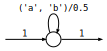

In [3]:
a2b = FST(Float)
a2b.add_I(0, 1.0)
a2b.add_arc(0, ('a', 'b'), 0, 0.5)
a2b.add_F(0, 1.0)

assert a2b('aaa', 'bbb') == 0.5**3
a2b

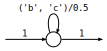

In [4]:
b2c = FST(Float)
b2c.add_I(0, 1.0)
b2c.add_arc(0, ('b', 'c'), 0, 0.5)
b2c.add_F(0, 1.0)

assert b2c('bb', 'cc') == 0.5**2
b2c

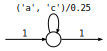

In [5]:
a2c = a2b @ b2c
a2c.trim

In [6]:
print(a2c('aaa', 'ccc') )

0.015625


In [7]:
x = a2b('a', None).trim

In [8]:
x('b')

0.5

In [9]:
x

In [10]:
x = a2b('a', None).trim.renumber
x

In [11]:
x = a2b(None, 'b').trim.renumber
x

In [12]:
x('a')

0.5

In [13]:
x(['a'])

0.5

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print(f'token vocabulary size: {tokenizer.vocab_size}')
T = [(token_id, tokenizer.decode([token_id])) for token_id in range(tokenizer.vocab_size)]

token vocabulary size: 50257


In [15]:
import random
random.seed(8675309)
S = random.sample(T, 5)
S

[(26361, 'zon'),
 (14032, ' purple'),
 (33439, ' MIDI'),
 (43499, 'announced'),
 (33034, ' hardened')]

Output()

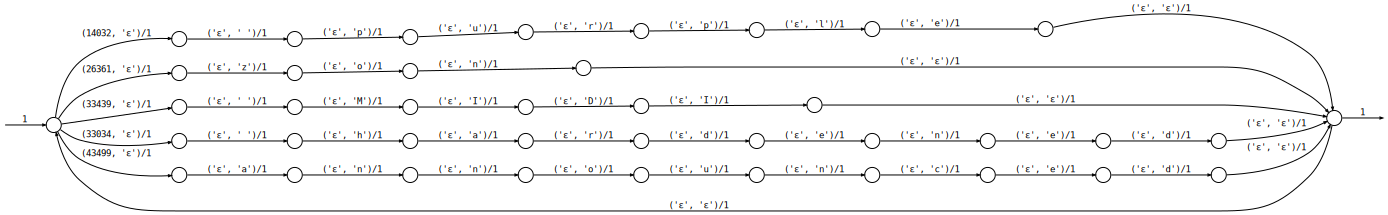

In [16]:
m = FST(Float)
m.add_I('<s>', 1)
for i, x in iterview(S): 
    m.add_arc('<s>', (i, EPSILON), (i, 0), 1)
    for j in range(len(x)):
        m.add_arc((i,j), (EPSILON, x[j]), (i,j+1), 1)
    m.add_arc((i,len(x)), (EPSILON, EPSILON), '</s>', 1)
m.add_F('</s>', 1)
m.add_arc('</s>', (EPSILON, EPSILON), '<s>', 1)
m

In [17]:
from genparse.util import LarkStuff

In [18]:
lark_stuff = LarkStuff("""

start: [ KEYWORD | INTEGER | BOOLEAN ] EOS

EOS: "</s>"
NAME: /[A-Za-z]+/
KEYWORD: "SELECT" | "WHERE" | "FROM"
INTEGER: /[1-9][0-9]*/
BOOLEAN: "true"  | "false"
    
""")

In [19]:
m = lark_stuff.transducer()

In [20]:
tmp = m('SELECT', None).trim.epsremove.trim
tmp

In [21]:
tmp = m('SELECT\n\t\r FROM 1 2', None).trim.epsremove.trim#.min
tmp

In [22]:
tmp = m('SELECT\nFROM', ('KEYWORD', 'KEYWORD'))
tmp

0.99